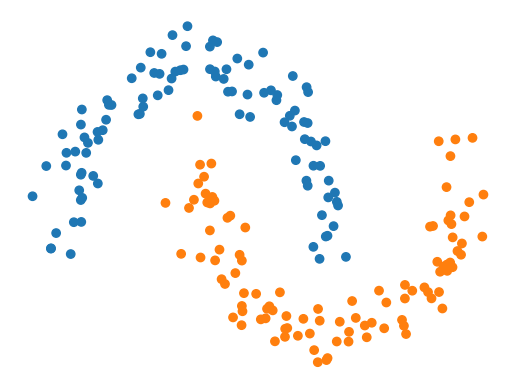

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
import torch

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [14]:
import pennylane as qml

n_qubits= 2
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [15]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [16]:
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

In [17]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [18]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

/tmp/ipykernel_694586/1680573023.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, requires_grad=True).float()


Average loss over epoch 1: 0.4929
Average loss over epoch 2: 0.3815
Average loss over epoch 3: 0.2376
Average loss over epoch 4: 0.1864
Average loss over epoch 5: 0.1720
Average loss over epoch 6: 0.1625
Accuracy: 86.5%


# Real Data on pennylane circuit

In [2]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    BCELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

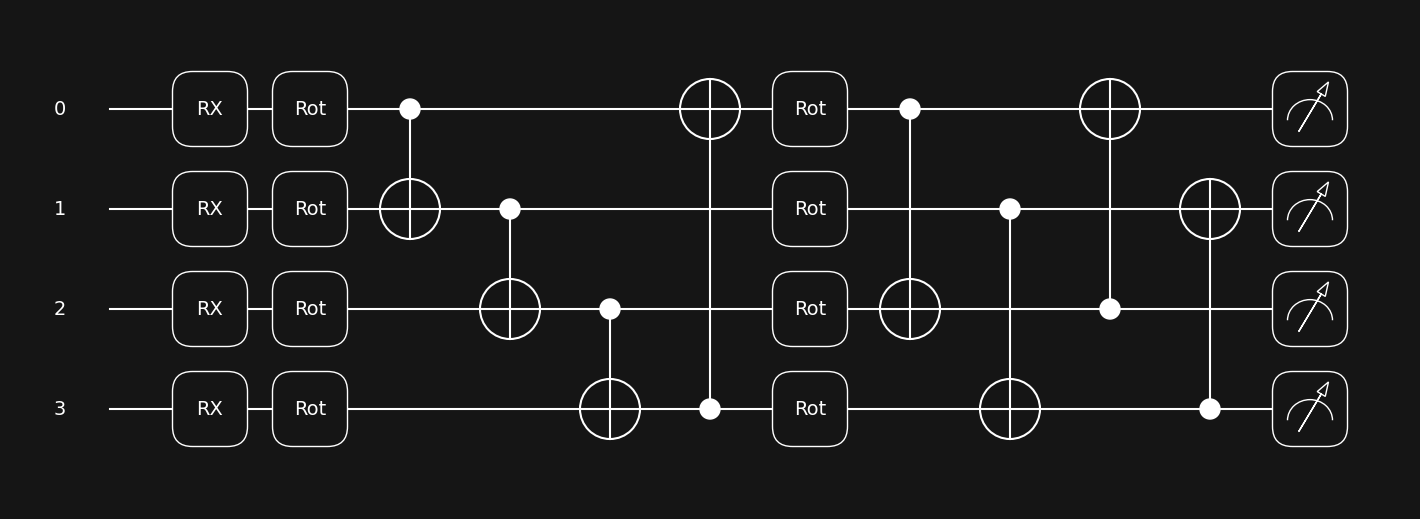

In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt
n_qubits= 4
n_layers = 2

# shape (L, M, 3) for stronglyEntanglingLaters
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch', diff_method='backprop')
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
params = torch.rand(shape)
inputs = torch.rand(n_qubits) 
qml.draw_mpl(qnode, level='device', style='black_white_dark')(inputs, params)
plt.show()

In [42]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())  
print(torch.cuda.device_count())  
print(torch.cuda.get_device_name(0))

class Net(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(5, 8)
        self.fc3 = Linear(8, 4)
        self.qnn = qlayer
        self.fc4 = Linear(4, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = self.qnn(x)
        x = torch.sigmoid(self.fc4(x))
        return x


model = Net().to(device)

True
1
NVIDIA RTX A6000


In [44]:
import pandas as pd
path = "./Fish.csv"
df = pd.read_csv(path)
print(df.head())
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X = df.drop(columns=["Species", "Weight"]).values
y = df["Weight"].values.reshape(-1, 1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"train_data: {X_train.shape}, val_data: {X_val.shape}, test_data: {X_test.shape}")

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
train_data: (127, 5), val_data: (16, 5), test_data: (16, 5)


In [45]:
# Transform to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
from torch.utils.data import TensorDataset, DataLoader

batch_size = 2

# dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [46]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_func = BCELoss().to(device)

# Start training
epochs = 30  # Set number of epochs
loss_list = []  # Store loss history

In [47]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        loss.backward() 
        optimizer.step() 
        total_loss += loss.item()
    if epoch+1 in [5, 10, 15, 20, 25, 30]:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "./output/qnn_model.pt")
print("Save Model successfully")

Epoch 5/30, Loss: 0.5547
Epoch 10/30, Loss: 0.4780
Epoch 15/30, Loss: 0.4529
Epoch 20/30, Loss: 0.4418
Epoch 25/30, Loss: 0.4391
Epoch 30/30, Loss: 0.4338
Save Model successfully


In [1]:
import pennylane as qml
import torch
import torch.nn as nn

# 1. 設定量子裝置
dev = qml.device("default.qubit", wires=4)

# 2. 定義量子神經網路 (QNode)，並引入可訓練參數
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):  # 加入 weights
    qml.AngleEmbedding(inputs, wires=range(4))
    qml.BasicEntanglerLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

# 3. 定義權重的形狀
weight_shapes = {"weights": (3, 4)}  # 3 層，每層 4 個參數

# 4. 使用 TorchLayer 包裝 QNode
qnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes=weight_shapes)

# 5. 創建完整模型 (QNN + Fully Connected Layer)
model = nn.Sequential(
    qnn_layer,       # 量子神經網路層，輸出 (batch, 4)
    nn.Linear(4, 10) # Fully Connected，輸出 (batch, 10)
)

# 6. 查看 `qnn_layer` 是否有可訓練參數
print("Trainable parameters in qnn_layer:")
for name, param in model.named_parameters():
    print(name, param.shape)


Trainable parameters in qnn_layer:
0.weights torch.Size([3, 4])
1.weight torch.Size([10, 4])
1.bias torch.Size([10])
